In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rc('font', size=12)

In [2]:
class MLP(nn.Module):
    """ Multilayer perceptron (MLP) with tanh/sigmoid activation functions implemented in PyTorch for regression tasks.

    Attributes:
        inputs (int): inputs of the network
        outputs (int): outputs of the network
        hidden_layers (list): layer structure of MLP: [5, 5] (2 hidden layer with 5 neurons)
        activation (string): activation function used ('relu', 'tanh' or 'sigmoid')

    """

    def __init__(self, inputs=1, outputs=1, hidden_layers=[100], activation='relu'):
        super(MLP, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        self.hidden_layers = hidden_layers
        self.nLayers = len(hidden_layers)
        self.net_structure = [inputs, *hidden_layers, outputs]
        
        if activation == 'relu':
            self.act = torch.relu
        elif activation == 'tanh':
            self.act = torch.tanh
        elif activation == 'sigmoid':
            self.act = torch.sigmoid
        else:
            assert('Use "relu","tanh" or "sigmoid" as activation.')
        # create linear layers y = Wx + b

        for i in range(self.nLayers + 1):
            setattr(self, 'layer_'+str(i), nn.Linear(self.net_structure[i], self.net_structure[i+1]))

    def forward(self, x):
        # connect layers
        for i in range(self.nLayers):
            layer = getattr(self, 'layer_'+str(i))
            x = self.act(layer(x))
        layer = getattr(self, 'layer_' + str(self.nLayers))
        x = layer(x)
        return x

In [3]:
class GaussianMLP(MLP):
    """ Gaussian MLP which outputs are mean and variance.

    Attributes:
        inputs (int): number of inputs
        outputs (int): number of outputs
        hidden_layers (list of ints): hidden layer sizes

    """

    def __init__(self, inputs=1, outputs=1, hidden_layers=[100], activation='relu'):
        super(GaussianMLP, self).__init__(inputs=inputs, outputs=2*outputs, hidden_layers=hidden_layers, activation=activation)
        self.inputs = inputs
        self.outputs = outputs
    def forward(self, x):
        # connect layers
        for i in range(self.nLayers):
            layer = getattr(self, 'layer_'+str(i))
            x = self.act(layer(x))
        layer = getattr(self, 'layer_' + str(self.nLayers))
        x = layer(x)
        mean, variance = torch.split(x, self.outputs, dim=1)
        variance = F.softplus(variance) + 1e-6
        return mean, variance

In [4]:
class GaussianMixtureMLP(nn.Module):
    """ Gaussian mixture MLP which outputs are mean and variance.

    Attributes:
        models (int): number of models
        inputs (int): number of inputs
        outputs (int): number of outputs
        hidden_layers (list of ints): hidden layer sizes

    """
    def __init__(self, num_models=5, inputs=1, outputs=1, hidden_layers=[100], activation='relu'):
        super(GaussianMixtureMLP, self).__init__()
        self.num_models = num_models
        self.inputs = inputs
        self.outputs = outputs
        self.hidden_layers = hidden_layers
        self.activation = activation
        for i in range(self.num_models):
            model = GaussianMLP(inputs=self.inputs, 
                                outputs=self.outputs, 
                                hidden_layers=self.hidden_layers,
                                activation=self.activation)
            setattr(self, 'model_'+str(i), model)
            
    def forward(self, x):
        # connect layers
        means = []
        variances = []
        for i in range(self.num_models):
            model = getattr(self, 'model_' + str(i))
            mean, var = model(x)
            means.append(mean)
            variances.append(var)
        means = torch.stack(means)
        mean = means.mean(dim=0)
        variances = torch.stack(variances)
        variance = (variances + means.pow(2)).mean(dim=0) - mean.pow(2)
        return mean, variance

In [5]:
def NLLloss(y, mean, var):
    """ Negative log-likelihood loss function. """
    return (torch.log(var) + ((y - mean).pow(2))/var).sum()    

Toy regression example, reproduction of the results in the paper
We consider the function 
 as the ground truth.

The data is generated by sampling from 
, where 
.

Used neural network architecture: 1 layer, 100 hidden units, ReLU activation

Reference [24]: https://arxiv.org/pdf/1502.05336.pdf

import matplotlib.pyplot as plt

In [6]:
def data_set(points=20, xrange=(-4, 4), std=3.):
    xx = torch.tensor([[np.random.uniform(*xrange)] for i in range(points)])
    yy = torch.tensor([[x**3 + np.random.normal(0, std)] for x in xx])
    return xx, yy

Comparison of standard MLP, Gaussian MLP and Gaussian Mixture MLP
Training
Parameters from the paper:

Batch size = 100 (only 20 samples?)

Epochs = 40

Optimizer: Adam with step size 0.1

Instead of training for 40 epochs on a batch size of 100, we train on 200 epochs on a batch size of 20 (whole data set).

In [7]:
epochs = 200
learning_rate = 0.1

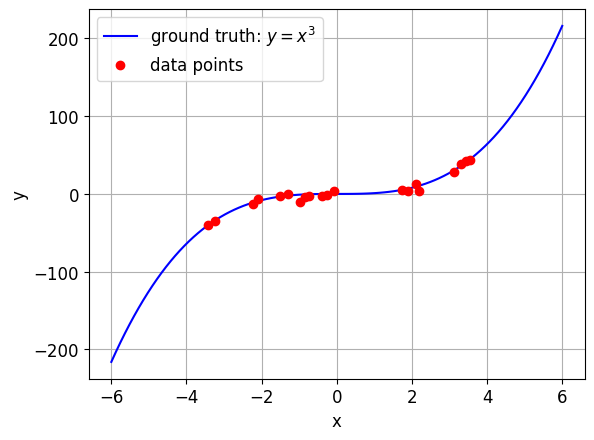

In [8]:
xx, yy = data_set(points=20, xrange=(-4, 4), std=3.) # generate data set of 20 samples
x = np.linspace(-6, 6, 100).reshape(100, 1)
y = x**3
plt.plot(x, y, 'b-', label='ground truth: $y=x^3$')
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [9]:
mlp = MLP(hidden_layers=[100], activation='relu') # standard MLP
mlp_optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate)
mlp_criterion = nn.MSELoss()

In [10]:
for epoch in range(epochs):
    mlp_optimizer.zero_grad()
    mlp_loss = mlp_criterion(yy, mlp(xx))
    if epoch == 0:
        print('initial loss: ',mlp_loss.item())
    mlp_loss.backward()
    mlp_optimizer.step()
print('final loss: ',mlp_loss.item())

initial loss:  475.2584533691406
final loss:  8.739136695861816


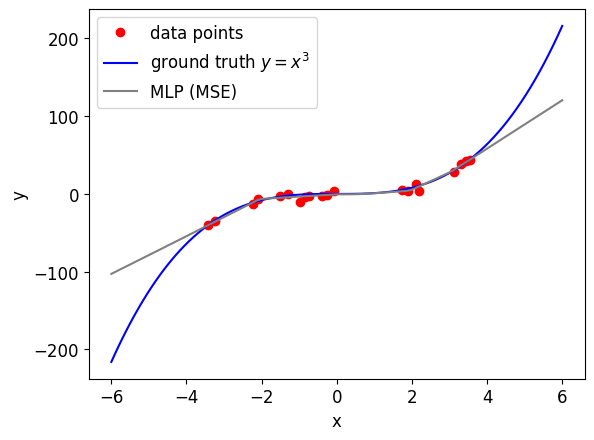

In [11]:
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.plot(x, y, 'b', label='ground truth $y=x^3$')
plt.plot(x, mlp(torch.tensor(x).float()).detach().numpy(), label='MLP (MSE)', color='grey')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [12]:
mlps = []
mlp_optimizers = []
mlp_criterion = nn.MSELoss()
M = 5
for _ in range(M):
    net = MLP(hidden_layers=[100], activation='relu') # standard MLP
    mlps.append(net)
    mlp_optimizers.append(torch.optim.Adam(params=net.parameters(), lr=learning_rate))
# train 
for i, net in enumerate(mlps):
    print('Training network ',i+1)
    for epoch in range(epochs):
        mlp_optimizers[i].zero_grad()
        mlp_loss = mlp_criterion(yy, net(xx))
        if epoch == 0:
            print('initial loss: ',mlp_loss.item())
        mlp_loss.backward()
        mlp_optimizers[i].step()
    print('final loss: ',mlp_loss.item())

Training network  1
initial loss:  451.4130859375
final loss:  8.499235153198242
Training network  2
initial loss:  481.99664306640625
final loss:  8.769457817077637
Training network  3
initial loss:  496.92083740234375
final loss:  8.984223365783691
Training network  4
initial loss:  496.40771484375
final loss:  7.704041957855225
Training network  5
initial loss:  464.03985595703125
final loss:  8.175243377685547


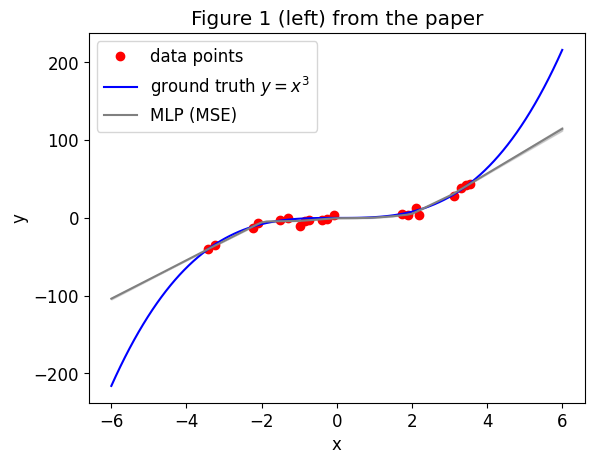

In [13]:
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.plot(x, y, 'b', label='ground truth $y=x^3$')
ys = []
for net in mlps:
    ys.append(net(torch.tensor(x).float()).detach().numpy())
ys = np.array(ys)
mean = np.mean(ys, axis=0)
std = np.std(ys, axis=0)
plt.plot(x, mean, label='MLP (MSE)', color='grey')
plt.fill_between(x.reshape(100,), (mean-std).reshape(100,), (mean+std).reshape(100,),color='grey',alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figure 1 (left) from the paper')
plt.legend()

In [14]:
gmlp = GaussianMLP(hidden_layers=[100]) 
gmlp_optimizer = torch.optim.Adam(params=gmlp.parameters(), lr=learning_rate)

In [15]:
for epoch in range(epochs*3):
    gmlp_optimizer.zero_grad()
    mean, var = gmlp(xx)
    gmlp_loss = NLLloss(yy, mean, var) #NLL loss
    #gmlp_loss = (yy - mean).pow(2).mean() # MSE loss for testing
    if epoch == 0:
        print('initial loss: ',gmlp_loss.item())
    gmlp_loss.backward()
    gmlp_optimizer.step()
print('final loss: ',gmlp_loss.item())

initial loss:  12245.892578125
final loss:  73.58412170410156


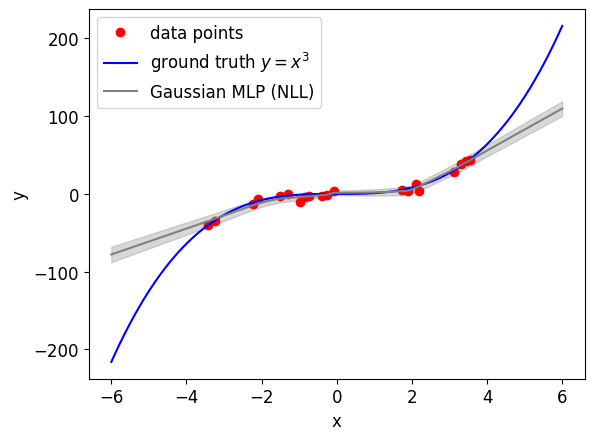

In [24]:
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.plot(x, y, 'b', label='ground truth $y=x^3$')
mean, var = gmlp(torch.tensor(x).float())
mean = mean.detach().numpy()
var = var.detach().numpy()
std = np.sqrt(var)
plt.plot(x, mean, 'grey', label='Gaussian MLP (NLL)')
plt.fill_between(x.reshape(100,), (mean-std).reshape(100,), (mean+std).reshape(100,),color='grey',alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Figure 1 (second from left) from the paper')
plt.legend()

In [17]:
def train_model_step(model, optimizer, x, y):
    """ Training an individual gaussian MLP of the deep ensemble. """
    optimizer.zero_grad()
    mean, var = model(x)
    loss = NLLloss(y, mean, var)
    loss.backward()
    optimizer.step()
    return loss.item()

In [18]:
def train_gmm_step(gmm, optimizers, x, y):
    """ Training the whole ensemble. """
    losses = []
    for i in range(gmm.num_models):
        model = getattr(gmm, 'model_' + str(i))
        loss = train_model_step(model, optimizers[i], x, y)
        losses.append(loss)
    return losses

In [19]:
gmm = GaussianMixtureMLP(num_models=5, hidden_layers=[100])
gmm_optimizers = []
for i in range(gmm.num_models):
    model = getattr(gmm, 'model_' + str(i))
    gmm_optimizers.append(torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=4e-5))

In [20]:
for epoch in range(epochs):
    losses = train_gmm_step(gmm, gmm_optimizers, xx, yy)
    if epoch == 0:
        print('inital losses: ', losses)
print('final losses: ', losses)

inital losses:  [9199.041015625, 16095.697265625, 8631.4970703125, 13734.6943359375, 14033.21875]
final losses:  [171.42308044433594, 107.04862213134766, 70.20996856689453, 92.68351745605469, 122.137451171875]


Text(0, 0.5, 'y')

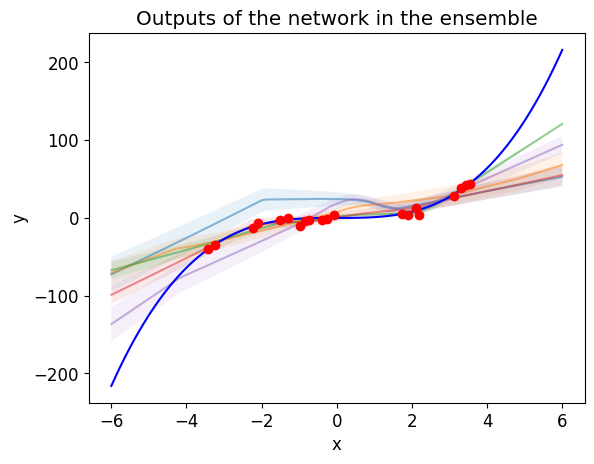

In [21]:
means = []
variances = []
for i in range(gmm.num_models):
    model = getattr(gmm, 'model_'+str(i))
    mean, var = model(torch.tensor(x).float())
    mean = mean.detach().numpy()
    var = var.detach().numpy()
    means.append(mean)
    variances.append(var)
    std = np.sqrt(var)
    plt.plot(x, mean, label='GMM (NLL) '+str(i+1),alpha=0.5)
    plt.fill_between(x.reshape(100,), (mean-std).reshape(100,), (mean+std).reshape(100,),alpha=0.1)
plt.plot(x, y, label='ground truth $y=x^3$', color='b')
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.title('Outputs of the network in the ensemble')
plt.xlabel('x')
plt.ylabel('y')

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anushree K S\AppData\Local\Temp\ipykernel_21000\1269687846.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(x.reshape(100,), (mean-std).reshape(100,), (mean+std).reshape(100,), color='grey',alpha=0.3, label='$\sigma$ - uncertainty estimated')


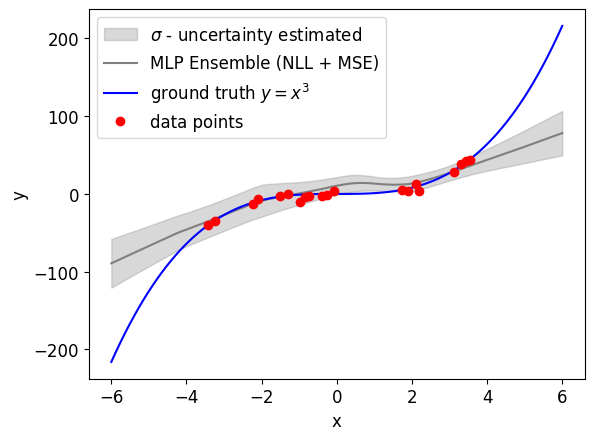

In [27]:
mean, var = gmm(torch.tensor(x).float())
mean = mean.detach().numpy()
var = var.detach().numpy()
std = np.sqrt(var)
#plt.fill_between(x.reshape(100,), (mean-var).reshape(100,), (mean+var).reshape(100,),color='red',alpha=0.1, label='$\sigma^2$')
plt.fill_between(x.reshape(100,), (mean-std).reshape(100,), (mean+std).reshape(100,), color='grey',alpha=0.3, label='$\sigma$ - uncertainty estimated')
plt.plot(x, mean, label='MLP Ensemble (NLL + MSE)',color='grey')
plt.plot(x, y, 'b', label='ground truth $y=x^3$')
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Figure 1 (right) from the paper')
plt.legend()